In [1]:
import numpy as np
import cv2

from scipy.misc import imread
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.core.debugger import Tracer
import warnings
from jupyterthemes import jtplot

#parallel execution
from joblib import Parallel, delayed
import multiprocessing

#user code
import features as FEATURES
from color_histogram import color_hist
from utils import draw_boxes
import search

In [2]:
%matplotlib inline
jtplot.style()
sns.set_context("poster")
# plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

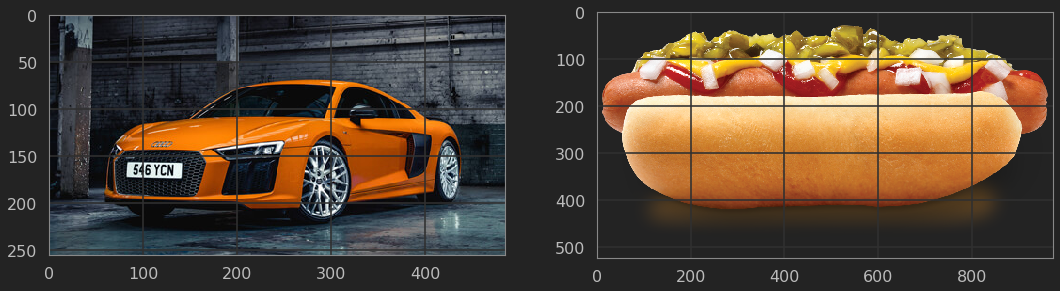

In [3]:
car = imread("r8.jpg")
notacar = imread("hot_dog.png")
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.imshow(car)
plt.subplot(122)
plt.imshow(notacar)

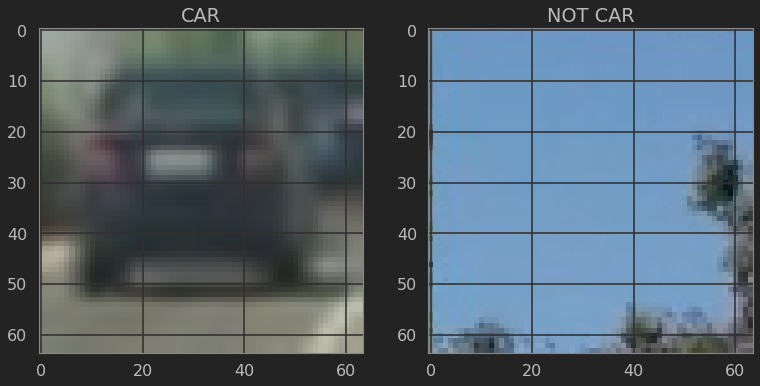

{'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3), 'data_type': dtype('uint8')}


In [4]:
#read in training data
cars = glob.glob('data/vehicles/**/*.png', recursive=True)
not_cars = glob.glob('data/non-vehicles/**/*.png', recursive=True)
data = np.concatenate([cars, not_cars])
data_dict = {}
data_dict["n_cars"] = len(cars)
data_dict["n_notcars"] = len(not_cars)
car = imread(cars[0])
notacar = imread(not_cars[0])
data_dict["image_shape"] = car.shape
data_dict["data_type"] = car.dtype

plt.subplot(121)
plt.title("CAR")
plt.imshow(car)
plt.subplot(122)
plt.title("NOT CAR")
plt.imshow(notacar)
plt.show()
print(data_dict)

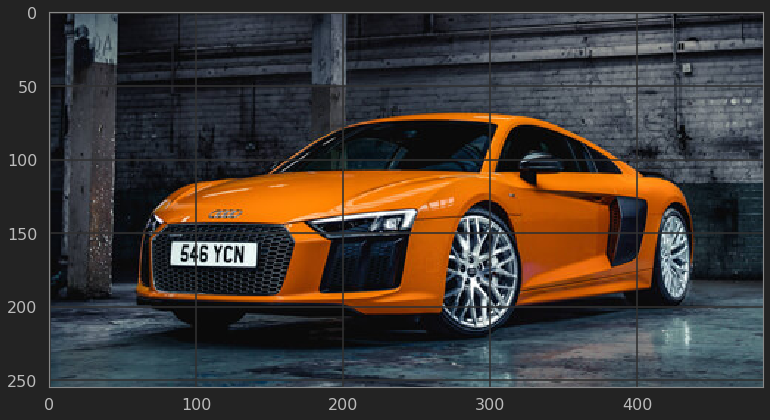

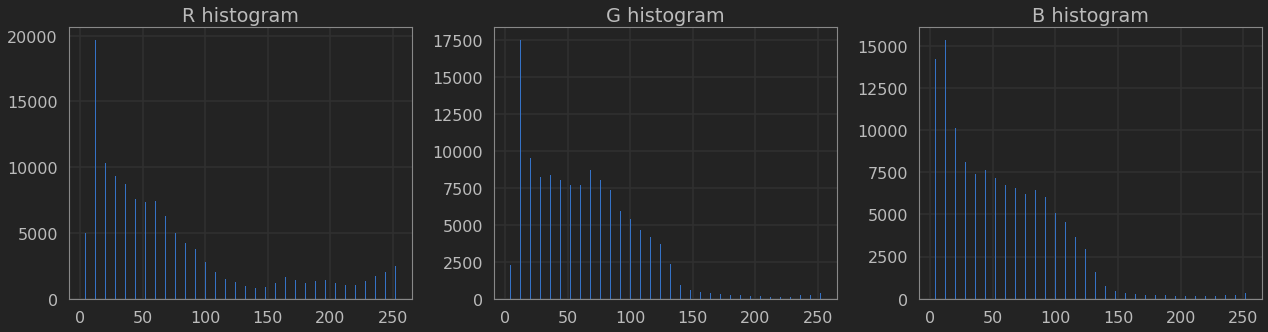

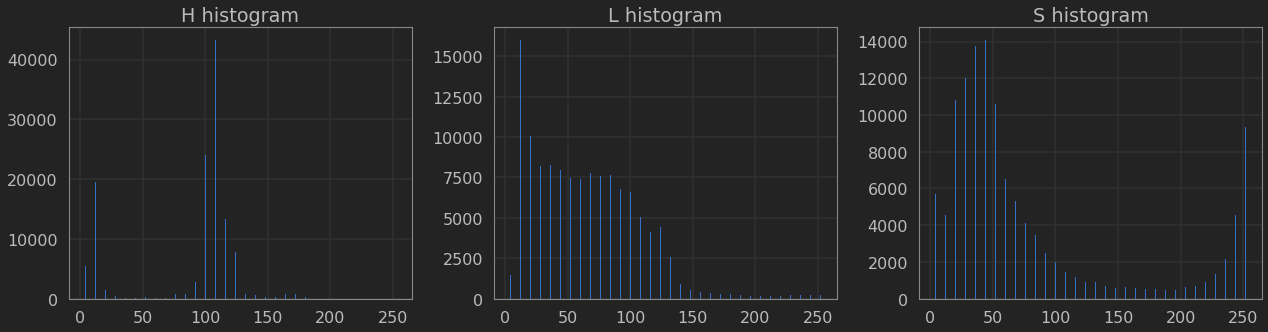

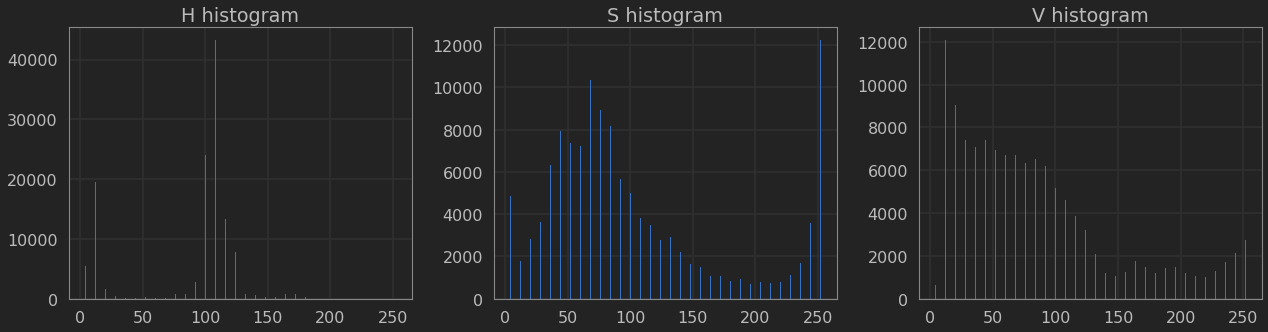

In [5]:
#lets look at the saturtion channel
test_image = imread("r8.jpg")
plt.imshow(test_image)
test_image_hls = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
test_image_hsv = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)

def show_histogram(image, title):
    #extract histogram features
    histogram_data = color_hist(image)
    plt.figure(figsize=(18,5))
    for i in range(3):
        data, points = histogram_data[i]
        plt.subplot(131 + i)
        plt.bar(points, data)
        plt.title(title[i] + " histogram")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(18,5))
show_histogram(test_image, "RGB")
plt.figure(figsize=(18,5))
show_histogram(test_image_hls, "HLS")
plt.figure(figsize=(18,5))
show_histogram(test_image_hsv, "HSV")

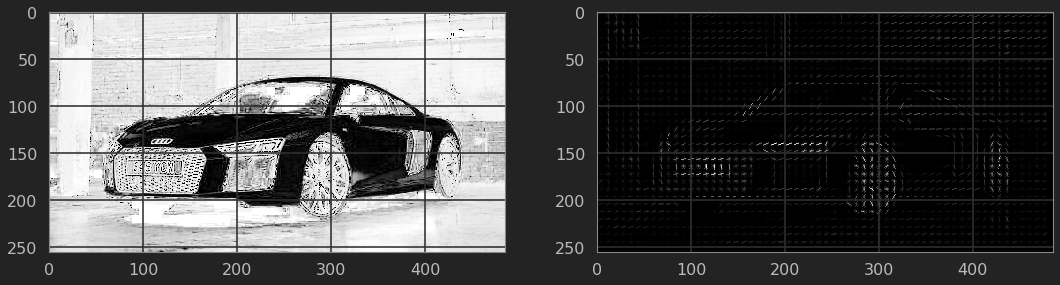

In [6]:
#extract hog features
from skimage.feature import hog
plt.figure(figsize=(18,5))
hog_output = features = hog(test_image_hls[:,:,1], orientations=9, 
                   pixels_per_cell=(8,8), 
                   cells_per_block=(2,2) ,
                   visualise=True)

plt.subplot(121)
plt.imshow(test_image_hls[:,:,2])
plt.subplot(122)
plt.imshow(hog_output[1],cmap="gray")

In [46]:
def featurizer(image, features):
    output = []
    for feature in features:
        output.append(feature(image))
        
    return np.concatenate(output)

In [8]:
features = [
    lambda x: FEATURES.color(x, 1, "HLS"),
    lambda x: FEATURES.color(x, 2, "HLS"),
    lambda x: FEATURES.color(x, 1, "HSV"),
    lambda x: FEATURES.color(x, 2, "HSV"),
    lambda x: FEATURES.HOG(x[:,:,2])
]


In [9]:
#process the data in parallel
num_cores = multiprocessing.cpu_count()
def processor(image_file_path):
    return featurizer(imread(image_file_path), features)
    
car_features = np.array(Parallel(n_jobs=num_cores)(
        delayed(processor)(i) for i in cars
    ), dtype=np.float32)

notcar_features = np.array(Parallel(n_jobs=num_cores)(
        delayed(processor)(i) for i in not_cars
    ), dtype=np.float32)

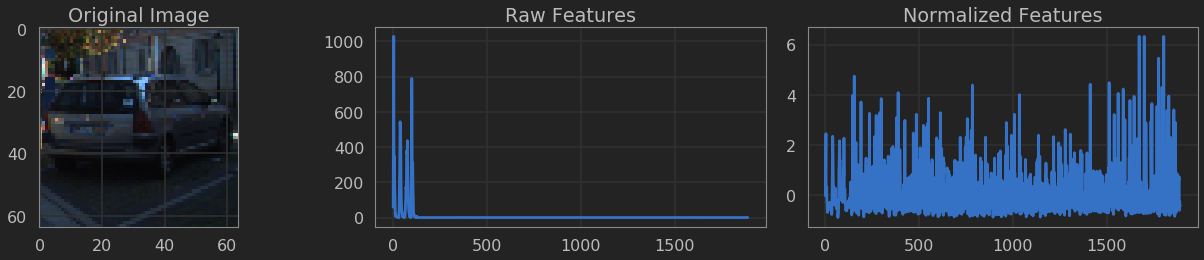

In [10]:
#normalize the data
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features))                      
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(car_features))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(18,4))
plt.subplot(131)
plt.imshow(imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
plt.tight_layout()


In [11]:
#create the dataset
labels = np.hstack([np.ones(len(cars)), np.zeros(len(not_cars))]).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, test_size=0.33, random_state=42)

In [12]:
#lets try a SVM classifier
# C_range = np.logspace(-2, 10, 13)
# gamma_range = np.logspace(-9, 3, 13)

# parameters = {'kernel':('rbf','sigmoid','poly'), 'C':C_range, 'gamma':gamma_range}
# svr = SVC()
# clf = GridSearchCV(svr, parameters)
# clf.fit(X_train[:2000], y_train[:2000])

In [13]:
#results of the search is a C value of 10 and auto gamma, rbf network
clf = SVC(C=10)
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
predictions = clf.predict(X_test)

In [15]:
#best with gamma=auto, C-10, rbf -> 0.98242620713188877
acc = sum([p == a for (p, a) in zip(predictions, y_test)])/float(len(y_test))
acc

0.99300460672240232

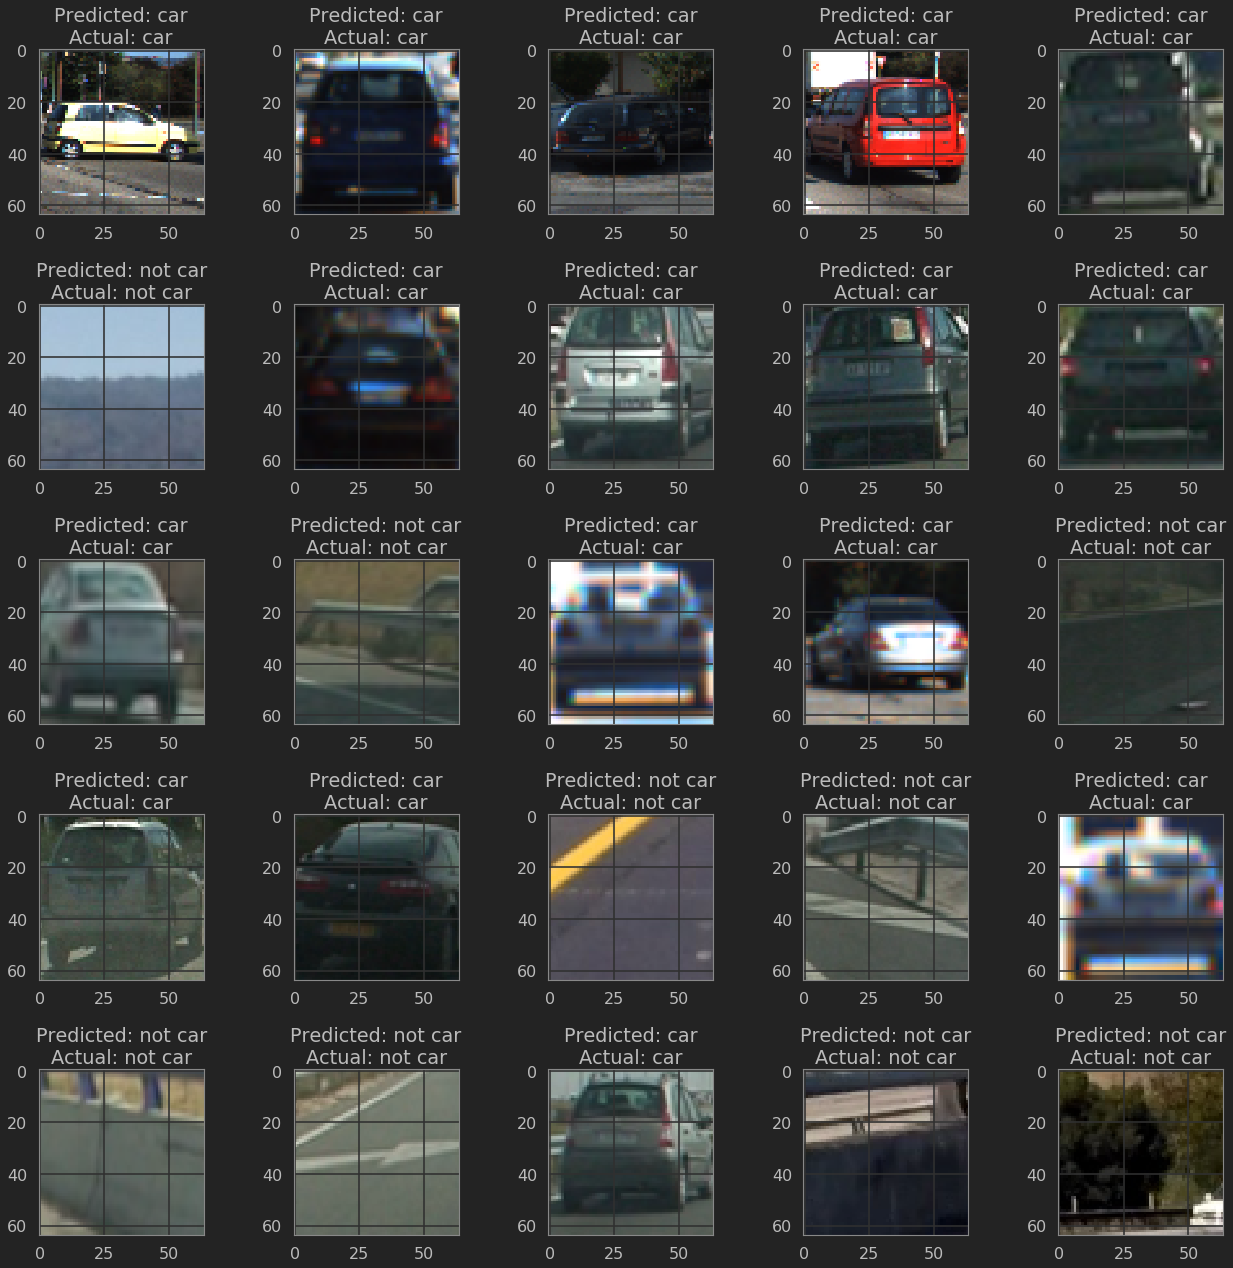

In [16]:
"lets look at some predictions and make sure they make sense"
plt.figure(figsize=(18,18))
eval_indices = np.random.randint(0, len(data), 25)
X_disp = X_scaler.transform([featurzier(imread(data[x]), features) for x in eval_indices])
y_disp = labels[eval_indices]
pred_disp = clf.predict(X_disp)
for i in range(5):
    for ii in range(5):
        index = i + 5*ii
        plt.subplot(5,5,index+1)
        lbls = ["not car", "car"]
        filename = data[eval_indices[index]]
        img = imread(filename)
        actual = y_disp[index]
        predicted = pred_disp[index]
        plt.title("Predicted: {}\nActual: {}".format(lbls[int(predicted)], lbls[int(actual)]))
        plt.imshow(img)
plt.tight_layout()
plt.show()

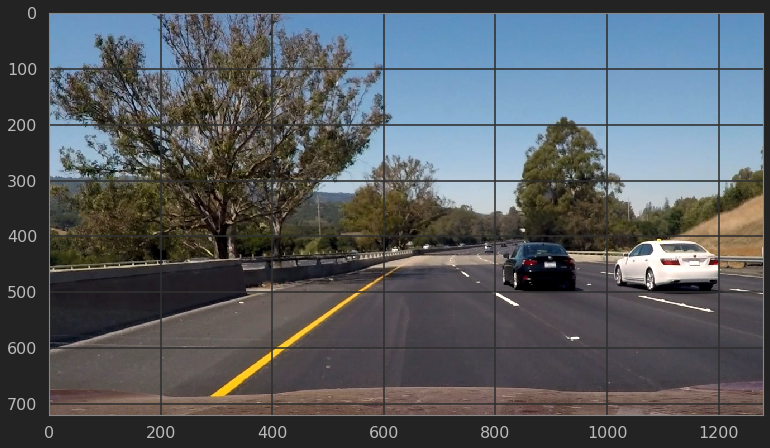

In [17]:
image = imread('../project_4/cnd-all/test_images/test6.jpg')
plt.imshow(image)

In [97]:
import numpy as np

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def windows_xxlarge(image): 
    return slide_window(image,
                        x_start_stop=[5,1280], 
                        y_start_stop=[330,720], 
                        xy_window=(320, 320), 
                        xy_overlap=(0.8, 0.0))

def windows_xlarge(image):
    return slide_window(image,
                        x_start_stop=[60,1250], 
                        y_start_stop=[350,700], 
                        xy_window=(256, 256), 
                        xy_overlap=(0.8, 0.0))

def windows_large(image): 
    return slide_window(image,
                        x_start_stop=[60,1250], 
                        y_start_stop=[350,620], 
                        xy_window=(192, 192), 
                        xy_overlap=(0.6, 0.6))

def windows_medium(image): 
    return slide_window(image,
                        x_start_stop=[60,1250], 
                        y_start_stop=[390,540], 
                        xy_window=(128, 128), 
                        xy_overlap=(0.8, 0.8))

def windows_small(image): 
    return slide_window(image,
                        x_start_stop=[250,1126], 
                        y_start_stop=[390,520], 
                        xy_window=(96, 96), 
                        xy_overlap=(0.8, 0.8))

def windows_xsmall(image): 
    return slide_window(image,
                        x_start_stop=[250,1126], 
                        y_start_stop=[390,480], 
                        xy_window=(64, 64), 
                        xy_overlap=(0.8, 0.8))
#define the windows
def get_windows(image):
    window_sets = [
        windows_xxlarge(image), windows_xlarge(image), windows_large(image), 
        windows_medium(image),windows_small(image), windows_xsmall(image)
    ]
    
    output = []
    for ws in window_sets:
        for window in ws:
            p1, p2 = window
            x1, y1 = p1
            x2, y2 = p2
            w = cv2.resize(image[y1:y2, x1:x2], (64,64))
            output.append((window, w))
        
    return output
    
    
def draw_windows(image):
    boxed = draw_boxes(image, windows_xxlarge, color=(0,255,255))
    boxed = draw_boxes(boxed, windows_xlarge, color=(255,56,0))
    boxed = draw_boxes(boxed, windows_large, color=(255,256,0))
    boxed = draw_boxes(boxed, windows_medium, color=(255,0,256))
    boxed = draw_boxes(boxed, windows_small, color=(54,128,256))
    boxed = draw_boxes(boxed, windows_xsmall, color=(256,128,128))
    
    return boxed

def processor(window):
    bounding_box, image = window
    return bounding_box, featurizer(image, features)

def get_windowed_features(image):
    windows = get_windows(image)
    
    return Parallel(n_jobs=num_cores)(
        delayed(processor)(w) for w in windows)

def detect_cars(image):
    windowed_features = get_windowed_features(image)
    X_features = X_scaler.transform(np.array([x[1] for x in windowed_features]))
    X_bounding_box = np.array([x[0] for x in windowed_features])
    predictions = clf.predict(X_features).astype(bool)
    return X_bounding_box[predictions]
    

In [98]:
def draw_boxes(img, bboxes, color=(255, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [94]:
detected_cars = detect_cars(image)
detected_cars

[([820, 350], [1012, 542]),
 ([1048, 350], [1240, 542]),
 ([810, 390], [938, 518]),
 ([835, 390], [963, 518]),
 ([860, 390], [988, 518]),
 ([1010, 390], [1138, 518]),
 ([1035, 390], [1163, 518]),
 ([1060, 390], [1188, 518]),
 ([1085, 390], [1213, 518]),
 ([839, 390], [935, 486]),
 ([801, 409], [897, 505]),
 ([820, 409], [916, 505]),
 ([839, 409], [935, 505]),
 ([858, 409], [954, 505]),
 ([934, 409], [1030, 505]),
 ([970, 414], [1034, 478])]

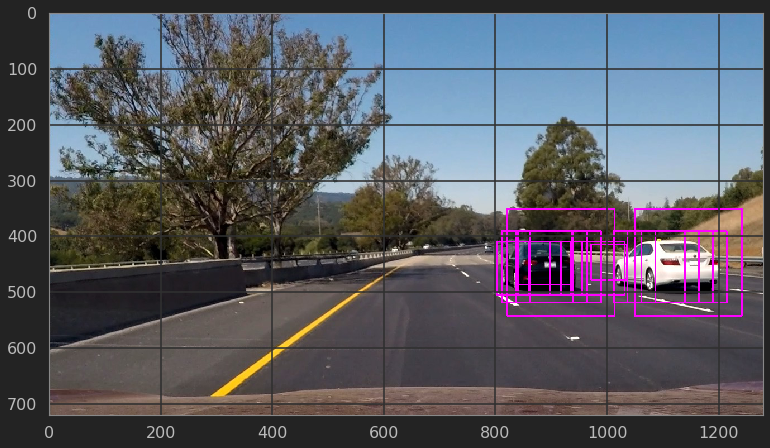

In [100]:
plt.imshow(draw_boxes(image, detected_cars))

In [85]:
detected_cars[0]

array([[ 820,  350],
       [1012,  542]])